頻率求解器 1.用於計算連續波元產生的場
下面維用頻率求解器計算環形場的分布
 分兩部分探討1.驗證疊帶越多次而誤差越小

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

amplitude symmetries意義?

In [2]:
n = 3.4
w = 1 
r = 1
pad = 4
dpml = 2 

cell = 2 * ( w + r + pad + dpml)
nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(cell - 2 * dpml, cell - 2 * dpml))



cell_size = mp.Vector3(cell,cell) 

pml_layers = [mp.PML(dpml)]

c1 = mp.Cylinder(radius = r + w,material=mp.Medium(index=n))
c2 = mp.Cylinder(radius = r)
geometry = [c1,c2]

fcen = 0.118

sources = [ mp.Source(mp.ContinuousSource(fcen) , mp.Ez , center = mp.Vector3(r+0.1)),
            mp.Source(mp.ContinuousSource(fcen) , mp.Ez , center = mp.Vector3(-(r+0.1)) , amplitude = -1,),
          ]

symmetries = [mp.Mirror(mp.X, phase = -1), mp.Mirror(mp.Y, phase = +1)]

In [3]:
sim = mp.Simulation(
      cell_size = cell_size,
      geometry = geometry,
      sources = sources,
      resolution = 10,
      force_complex_fields = True,
      symmetries = symmetries,
      boundary_layers = pml_layers,)

     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<function matplotlib.pyplot.show(close=None, block=None)>

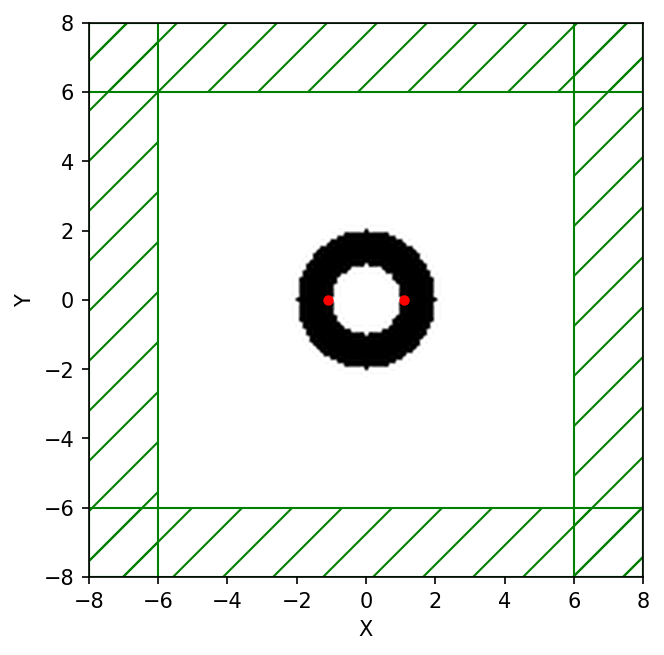

In [4]:
f = plt.figure(dpi = 150)
sim.plot2D(ax = f.gca())
plt.show

In [5]:
num_tols = 5
tols = np.power(10, np.arange(-8.0, -8.0 - num_tols, -1.0))
ez_dat = np.zeros((122, 122, num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 15)
    ez_dat[:, :, i] = sim.get_array(vol=nonpml_vol, component=mp.Ez)

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00162411 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.027951 s
-----------
Meep: using complex fields.
final residual = 9.90806e-09
Finished solve_cw after 102 CG iters (~ 3060 timesteps).
final residual = 5.41777e-10
Finished solve_cw after 102 CG iters (~ 3060 timesteps).
residual[105] = 2.58275e-08
on time step 3122 (time=156.1), 0.0012865 s/step
final residual = 6.43667e-11
Finished solve_cw after 116 CG iters (~ 3480 timesteps).
residual[103] = 1.3737e-10
on time step 3062 (time=

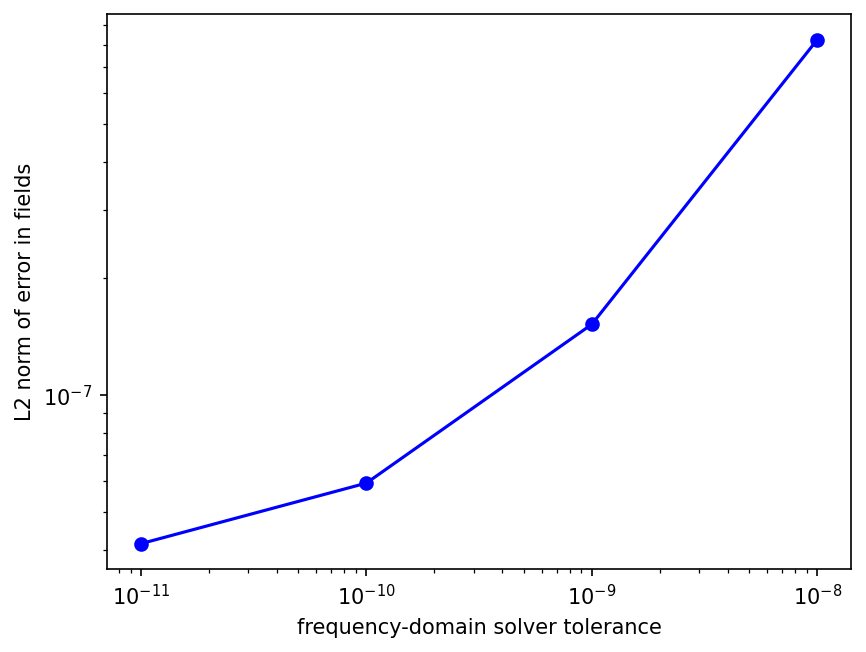

In [6]:
err_dat = np.zeros(num_tols-1)
for i in range(num_tols-1):
    err_dat[i] = LA.norm(ez_dat[:, :, i] - ez_dat[:, :, num_tols - 1])

plt.figure(dpi=150)
plt.loglog(tols[: num_tols - 1], err_dat, "bo-")
plt.xlabel("frequency-domain solver tolerance")
plt.ylabel("L2 norm of error in fields")
plt.show()

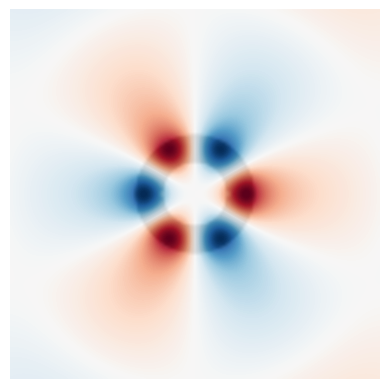

PASSED solve_cw test: error in the fields is decreasing with increasing resolution


In [7]:
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat[:, :, num_tols - 1])

plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="RdBu", alpha=0.9)
plt.axis("off")
plt.show()

if np.all(np.diff(err_dat) < 0):
    print(
        "PASSED solve_cw test: error in the fields is decreasing with increasing resolution"
    )
else:
    print(
        "FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution"
    )